<a href="https://colab.research.google.com/github/pbevan1/CycleGAN-Human-Anime-Translation/blob/main/Peter_Bevan_CycleGAN_Anime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#installing keras-contrib for instance normalisation
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-n36v3_xq
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-n36v3_xq
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=a5ba707558a25fe503b935894543b60b630a722f1b6abc5648cd1aea546b5251
  Stored in directory: /tmp/pip-ephem-wheel-cache-8q1xd2qk/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [2]:
#importing neccessary libraries

import zipfile
import os
import numpy as np
import shutil
from matplotlib import pyplot as plt
from random import sample
from random import random
from numpy.random import randint
from keras.models import load_model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Sequential
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Flatten
from keras.layers import Dense
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

In [4]:
#Setting random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)

# **!!!** Please note the image processing can be slow, if you wish go straight to model training please hide this part with the small magic arrow on the left and you will see where you can download preprocessed data from my google drive.


**Two sets of images are downloaded from Stephen McGough. 'PubFig' is a set of images of celebrity faces**

In [ ]:
#download anime and public figures images from Stephen McGough using curl
!curl -O http://homepages.cs.ncl.ac.uk/stephen.mcgough/Teaching/anime.zip
print('anime dataset downloaded to working directory')
!curl -O http://homepages.cs.ncl.ac.uk/stephen.mcgough/Teaching/PubFig.zip
print('public figure faces dataset downloaded to working directory')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  394M  100  394M    0     0  1093k      0  0:06:09  0:06:09 --:--:-- 1112k
anime dataset downloaded to working directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  175M  100  175M    0     0  1092k      0  0:02:44  0:02:44 --:--:-- 1092k
public figure faces dataset downloaded to working directory


**The downloaded files are unzipped into the working directory**

In [ ]:
#extracting zipped image files into directory
## Unzipping PubFig.zip
with zipfile.ZipFile('PubFig.zip', 'r') as zip_ref:
    zip_ref.extractall()
print('Public figure faces dataset extracted to working directory as "CelebDataProcessed/"\n')

## Unzipping anime.zip
with zipfile.ZipFile('anime.zip', 'r') as zip_ref:
    zip_ref.extractall()
print('Anime faces dataset extracted to working directory as "images/"')


Public figure faces dataset extracted to working directory as "CelebDataProcessed/"

Anime faces dataset extracted to working directory as "images/"


**The celeb data is rearranged to pull the images out of their labelled folders and place all images in the main directory (labels not used in CycleGAN). The empty folders are then deleted.**

In [ ]:
#renaming files in celeb data to be random unique names (so they can all reside in the same directory)
for root, dirs, files in os.walk('CelebDataProcessed/'):
    for name in files:
        newname = str(np.random.choice(range(1,17000))) + name
        os.rename(os.path.join(root,name), os.path.join(root,newname))

## moving all images out of labelled subdirectory and into the main folder
folder = r"CelebDataProcessed/" #defining folder to search
subfolders = [f.path for f in os.scandir(folder) if f.is_dir()] #defining subfolders
#looping through folders to move images
for sub in subfolders:
    for f in os.listdir(sub):
        src = os.path.join(sub, f)
        dst = os.path.join(folder, f)
        shutil.move(src, dst)

#deleting empty folders
path_abs=('CelebDataProcessed/') #defining path for empty folders
walk = list(os.walk(path_abs))
for path, _, _ in walk[::-1]:
    if len(os.listdir(path)) == 0:
        os.rmdir(path)

**The number of images loaded for each of the source and target are shown below.**

In [ ]:
#Printing image counts
celeb_image_count = len(os.listdir('CelebDataProcessed/'))
anime_image_count = len(os.listdir('images/'))
print(f'There are {celeb_image_count} images of celebrity faces (source)')
print(f'There are {anime_image_count} images of anime faces (target)')

There are 11000 images of celebrity faces (source)
There are 52000 images of anime faces (target)


In [ ]:
# Trimming down files to stop notebook running out of RAM whilst processing
def delete_files(filepath, number):
  for i, image in enumerate(os.listdir(filepath)):
    if i <= number:
      img_path = os.path.join(filepath,image)
      os.remove(img_path)

delete_files('/content/CelebDataProcessed', 596)
delete_files('/content/images', 7999)

#Reprinting image counts
celeb_image_count = len(os.listdir('CelebDataProcessed/'))
anime_image_count = len(os.listdir('images/'))
print(f'There are {celeb_image_count} images of celebrity faces (source)')
print(f'There are {anime_image_count} images of anime faces (target)')

In [ ]:
## Defining function to process images as numpy arrays and store locally as zipfile to save RAM

#defineing image size
image_size_source = (64,64)
image_size_target = (100,100)

def numpy_arrayify(desired_filename,filepath_source, filepath_target):
  #processing source images
  source_list = list()
  for filename in os.listdir(filepath_source):
    pic = load_img(filepath_source + filename, target_size=image_size_source)
    pic = img_to_array(pic)
    pic = pic.astype('float32')
    source_list.append(pic)
  source_list = np.asarray(source_list)
# processing target images
  target_list = list()
  for filename in os.listdir(filepath_target):
    pic2 = load_img(filepath_target + filename, target_size=image_size_target)
    pic2 = img_to_array(pic2)
    pic2 = pic2.astype('float32')
    target_list.append(pic2)
  target_list = np.asarray(target_list)
#crop anime faces to 64x64 and similar face size to celeb
  target_list = target_list[:, 26:90, 18:82, :]
# saving as zipped numpy file
  np.savez_compressed(desired_filename, source_list, target_list)

In [ ]:
# Using function on celeb and anime faces to save as single zip ready for training
numpy_arrayify('celeb_anime.npz','CelebDataProcessed/','images/')
print('------------------------------------------------------')
print('numpy arrays of images saved to environment as celeb_anime.npz')
print('------------------------------------------------------')

------------------------------------------------------
numpy arrays of images saved to environment as celeb_anime.npz
------------------------------------------------------


# **!!!** If you do not wish to wait for the above code to process the data, please download the preprocessed zipped numpy arrays containing the celebrity faces and anime faces (uncomment and run code block below as needed to download from my google drive into the environment)

In [11]:
## downloading preprocessed data
#!pip install gdown # Execute this if you don't have gdown
!gdown --id 1EdtNjgUeMUiUZVTm2MyUnUKIDnqm4Gee

Downloading...
From: https://drive.google.com/uc?id=1EdtNjgUeMUiUZVTm2MyUnUKIDnqm4Gee
To: /content/celeb_anime.npz
741MB [00:05, 142MB/s]


In [ ]:
#loading zipped file
data = np.load('celeb_anime.npz')
#assigning numpy arrays
celeb, anime = data['arr_0'], data['arr_1']

print('---------------------------------------')
print(f'Celeb data is shape: {celeb.shape}')
print('---------------------------------------')
print(f'Anime data is shape: {anime.shape}')
print('---------------------------------------')

---------------------------------------
Celeb data is shape: (11000, 64, 64, 3)
---------------------------------------
Anime data is shape: (44000, 64, 64, 3)
---------------------------------------


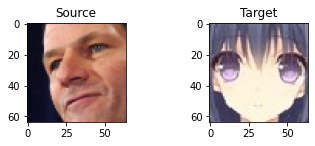

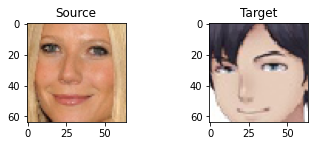

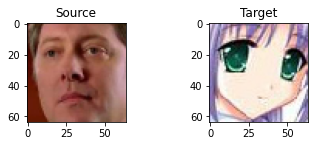

In [ ]:
### plotting sample of three of the source (celeb pics) and target (anime pics)
### side by side
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.set_title('Source')
ax1.imshow(celeb[666].astype('uint8'))
ax2 = fig.add_subplot(2,2,2)
ax2.set_title('Target')
ax2.imshow(anime[496].astype('uint8'))
fig = plt.figure()
ax3 = fig.add_subplot(2,2,1)
ax3.set_title('Source')
ax3.imshow(celeb[5].astype('uint8'))
ax4 = fig.add_subplot(2,2,2)
ax4.set_title('Target')
ax4.imshow(anime[667].astype('uint8'))
fig = plt.figure()
ax5 = fig.add_subplot(2,2,1)
ax5.set_title('Source')
ax5.imshow(celeb[2].astype('uint8'))
ax6 = fig.add_subplot(2,2,2)
ax6.set_title('Target')
ax6.imshow(anime[328].astype('uint8'));

The model was originally set to train at 200 epochs as specified in th implementation set out by the CycleGAN authors for horse to zebra translation. This was very slow and was looking at taking around a day. Since the number of training images was around 10 times that of the horse/zebra dataset, it was decided to divide the number of epochs using in the CycleGAN paper (200) by 10 (to 20). Furthe

# **Spectral normalisation**

In [ ]:
from keras import backend as K
from keras.engine import *
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils.generic_utils import deserialize_keras_object
from keras.utils.generic_utils import has_arg
from keras.utils import conv_utils
from keras.layers import Dense, Conv1D, Conv2D, Conv3D, Conv2DTranspose, Embedding
import tensorflow as tf


class DenseSN(Dense):
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)

        def power_iteration(W, u):
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        # Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        # Calculate Sigma
        sigma = K.dot(_v, W_reshaped)
        sigma = K.dot(sigma, K.transpose(_u))
        # normalize it
        W_bar = W_reshaped / sigma
        # reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
        output = K.dot(inputs, W_bar)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output


class _ConvSN(Layer):

    def __init__(self, rank,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='valid',
                 data_format=None,
                 dilation_rate=1,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 spectral_normalization=True,
                 **kwargs):
        super(_ConvSN, self).__init__(**kwargs)
        self.rank = rank
        self.filters = filters
        self.kernel_size = conv_utils.normalize_tuple(
            kernel_size, rank, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, rank, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.dilation_rate = conv_utils.normalize_tuple(
            dilation_rate, rank, 'dilation_rate')
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(ndim=self.rank + 2)
        self.spectral_normalization = spectral_normalization
        self.u = None

    def _l2normalize(self, v, eps=1e-12):
        return v / (K.sum(v ** 2) ** 0.5 + eps)

    def power_iteration(self, u, W):
        '''
        Accroding the paper, we only need to do power iteration one time.
        '''
        v = self._l2normalize(K.dot(u, K.transpose(W)))
        u = self._l2normalize(K.dot(v, W))
        return u, v

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        # Spectral Normalization
        if self.spectral_normalization:
            self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                     initializer=initializers.RandomNormal(
                                         0, 1),
                                     name='sn',
                                     trainable=False)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)

        def power_iteration(W, u):
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v

        if self.spectral_normalization:
            W_shape = self.kernel.shape.as_list()
            # Flatten the Tensor
            W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
            _u, _v = power_iteration(W_reshaped, self.u)
            # Calculate Sigma
            sigma = K.dot(_v, W_reshaped)
            sigma = K.dot(sigma, K.transpose(_u))
            # normalize it
            W_bar = W_reshaped / sigma
            # reshape weight tensor
            if training in {0, False}:
                W_bar = K.reshape(W_bar, W_shape)
            else:
                with tf.control_dependencies([self.u.assign(_u)]):
                    W_bar = K.reshape(W_bar, W_shape)

            # update weitht
            self.kernel = W_bar

        if self.rank == 1:
            outputs = K.conv1d(
                inputs,
                self.kernel,
                strides=self.strides[0],
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate[0])
        if self.rank == 2:
            outputs = K.conv2d(
                inputs,
                self.kernel,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.rank == 3:
            outputs = K.conv3d(
                inputs,
                self.kernel,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0],) + tuple(new_space) + (self.filters,)
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0], self.filters) + tuple(new_space)

    def get_config(self):
        config = {
            'rank': self.rank,
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding,
            'data_format': self.data_format,
            'dilation_rate': self.dilation_rate,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(_Conv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class ConvSN2D(Conv2D):

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)

        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)

        def power_iteration(W, u):
            # Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        # Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        # Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        # Calculate Sigma
        sigma = K.dot(_v, W_reshaped)
        sigma = K.dot(sigma, K.transpose(_u))
        # normalize it
        W_bar = W_reshaped / sigma
        # reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)

        outputs = K.conv2d(
            inputs,
            W_bar,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs


class ConvSN1D(Conv1D):

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)

        def power_iteration(W, u):
            # Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        # Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        # Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        # Calculate Sigma
        sigma = K.dot(_v, W_reshaped)
        sigma = K.dot(sigma, K.transpose(_u))
        # normalize it
        W_bar = W_reshaped / sigma
        # reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)

        outputs = K.conv1d(
            inputs,
            W_bar,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs


class ConvSN3D(Conv3D):
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)

        def power_iteration(W, u):
            # Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        # Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        # Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        # Calculate Sigma
        sigma = K.dot(_v, W_reshaped)
        sigma = K.dot(sigma, K.transpose(_u))
        # normalize it
        W_bar = W_reshaped / sigma
        # reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)

        outputs = K.conv3d(
            inputs,
            W_bar,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs


class EmbeddingSN(Embedding):

    def build(self, input_shape):
        self.embeddings = self.add_weight(
            shape=(self.input_dim, self.output_dim),
            initializer=self.embeddings_initializer,
            name='embeddings',
            regularizer=self.embeddings_regularizer,
            constraint=self.embeddings_constraint,
            dtype=self.dtype)

        self.u = self.add_weight(shape=tuple([1, self.embeddings.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)

        self.built = True

    def call(self, inputs):
        if K.dtype(inputs) != 'int32':
            inputs = K.cast(inputs, 'int32')

        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)

        def power_iteration(W, u):
            # Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.embeddings.shape.as_list()
        # Flatten the Tensor
        W_reshaped = K.reshape(self.embeddings, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        # Calculate Sigma
        sigma = K.dot(_v, W_reshaped)
        sigma = K.dot(sigma, K.transpose(_u))
        # normalize it
        W_bar = W_reshaped / sigma
        # reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
        self.embeddings = W_bar

        out = K.gather(self.embeddings, inputs)
        return out


class ConvSN2DTranspose(Conv2DTranspose):

    def build(self, input_shape):
        if len(input_shape) != 4:
            raise ValueError('Inputs should have rank ' +
                             str(4) +
                             '; Received input shape:', str(input_shape))
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (self.filters, input_dim)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)

        # Set input spec.
        self.input_spec = InputSpec(ndim=4, axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        if self.output_padding is None:
            out_pad_h = out_pad_w = None
        else:
            out_pad_h, out_pad_w = self.output_padding

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_length(height,
                                              stride_h, kernel_h,
                                              self.padding,
                                              out_pad_h)
        out_width = conv_utils.deconv_length(width,
                                             stride_w, kernel_w,
                                             self.padding,
                                             out_pad_w)
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)

        # Spectral Normalization
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)

        def power_iteration(W, u):
            # Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        # Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        # Calculate Sigma
        sigma = K.dot(_v, W_reshaped)
        sigma = K.dot(sigma, K.transpose(_u))
        # normalize it
        W_bar = W_reshaped / sigma
        # reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
        self.kernel = W_bar

        outputs = K.conv2d_transpose(
            inputs,
            self.kernel,
            output_shape,
            self.strides,
            padding=self.padding,
            data_format=self.data_format)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

# **Main model**

In [5]:
# define the discriminator model

# def define_discriminator(image_shape, filepath='NULL'):
# 	# weight initialization
# 	init = RandomNormal(stddev=0.02)
# 	# source image input
# 	in_image = Input(shape=image_shape)
# 	# C64
# 	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
# 	d = LeakyReLU(alpha=0.2)(d)
# 	# C128
# 	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
# 	d = InstanceNormalization(axis=-1)(d)
# 	d = LeakyReLU(alpha=0.2)(d)
# 	# C256
# 	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
# 	d = InstanceNormalization(axis=-1)(d)
# 	d = LeakyReLU(alpha=0.2)(d)
# 	# C512
# 	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
# 	d = InstanceNormalization(axis=-1)(d)
# 	d = LeakyReLU(alpha=0.2)(d)
# 	# second last output layer
# 	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
# 	d = InstanceNormalization(axis=-1)(d)
# 	d = LeakyReLU(alpha=0.2)(d)
# 	# patch output
# 	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
# 	# define model
# 	model = Model(in_image, patch_out)
#   # compile model
# 	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
# 	if filepath != 'NULL':
# 		model.load_weights(filepath)
# 	return model

def build_discriminator_sn(shape):
    model = Sequential()

    model.add(
        Conv2D(
            64, (3, 3), strides=(
                2, 2), padding="same", input_shape=shape))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(512, (3, 3), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(0.2))

    #model.add(Conv2D(1, (3, 3), padding="same"))
    model.add(Flatten())
    # model.add(GlobalAveragePooling2D())
    model.add(Dense(1))
    # model.add(Activation('sigmoid'))

    # compile model
    model.compile(loss='mse', optimizer=Adam(lr=0.0001, beta_1=0.5), loss_weights=[0.5])

    return model
 
# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g
 
# define the standalone generator model
def define_generator(image_shape, n_resnet=9, filepath='NULL'):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	if filepath != 'NULL':
		model.load_weights(filepath)
	return model
 
# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape, filepath='NULL'):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0001, beta_1=0.5)
  ## loading in previous weights from crashed training run
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	if filepath != 'NULL':
		model.load_weights(filepath)
	return model
 
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = np.load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
 
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return X, y
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y
 
# save the models to file
def save_weights(step, g_model_AtoB, g_model_BtoA, d_model_A, d_model_B, c_model_AtoB, c_model_BtoA):
	# save the first generator model
	filename1 = '/content/drive/MyDrive/COLAB3/g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save_weights(filename1)
	# save the second generator model
	filename2 = '/content/drive/MyDrive/COLAB3/g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save_weights(filename2)
#  # save the first generator model
# 	filename1 = '/content/drive/MyDrive/COLAB3/d_model_A_%06d.h5' % (step+1)
# 	d_model_A.save_weights(filename1)
# 	# save the second generator model
# 	filename2 = '/content/drive/MyDrive/COLAB3/d_model_B_%06d.h5' % (step+1)
# 	d_model_B.save_weights(filename2)
#  # save the first generator model
# 	filename1 = '/content/drive/MyDrive/COLAB3/c_model_AtoB_%06d.h5' % (step+1)
# 	c_model_AtoB.save_weights(filename1)
# 	# save the second generator model
# 	filename2 = '/content/drive/MyDrive/COLAB3/c_model_BtoA_%06d.h5' % (step+1)
# 	c_model_BtoA.save_weights(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))
 
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_out[i])
	# save plot to file
	filename1 = '/content/drive/MyDrive/COLAB3/%s_generated_plot_%06d.png' % (name, (step+1))
	plt.savefig(filename1)
	plt.close()
 
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random.random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return np.asarray(selected)
 
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 3, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % 4999 == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % 4999 == 0:
			# save the models
			save_weights(i, g_model_AtoB, g_model_BtoA, d_model_A, d_model_B, c_model_AtoB, c_model_BtoA)
 


In [31]:
# load image data
dataset = load_real_samples('/content/drive/MyDrive/COLAB3/celeb_anime.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
g_model_AtoB.load_weights('/content/drive/MyDrive/COLAB3/g_model_AtoB_030006.h5')
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
g_model_BtoA.load_weights('/content/drive/MyDrive/COLAB3/g_model_BtoA_030006.h5')
# discriminator: A -> [real/fake]
d_model_A = build_discriminator_sn(image_shape)
d_model_A.load_weights('/content/drive/MyDrive/COLAB3/d_model_A_030006.h5')
# discriminator: B -> [real/fake]
d_model_B = build_discriminator_sn(image_shape)
d_model_A.load_weights('/content/drive/MyDrive/COLAB3/d_model_B_030006.h5')
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
c_model_AtoB.load_weights('/content/drive/MyDrive/COLAB3/c_model_AtoB_030006.h5')
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
c_model_BtoA.load_weights('/content/drive/MyDrive/COLAB3/c_model_BtoA_030006.h5')

Loaded (11000, 64, 64, 3) (44000, 64, 64, 3)


In [ ]:
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

# **Testing**

In [11]:
# test faces can be downloaded from here
# !pip install gdown # Execute this if you don't have gdown

#Test faces
!gdown --id 1ovsaUTiYSAp-Sf9yal7_Icl8B83HyJb5
# Generator weights A--->B
!gdown --id 14PgXAzfCCnvWsiR9_LBqta83mV928QDM
# Generator weights B--->A
!gdown --id 14GIOGKmvFqYQN87WK27bGvd0AFvvVVDP

# extracting zipped test face image files into directory
# Unzipping 'Test images.zip'
with zipfile.ZipFile('Test images.zip', 'r') as zip_ref:
    zip_ref.extractall()
print('Test faces extracted to working directory as "Test images/"\n')

Downloading...
From: https://drive.google.com/uc?id=14GIOGKmvFqYQN87WK27bGvd0AFvvVVDP
To: /content/g_model_BtoA_010004.h5
141MB [00:02, 69.9MB/s]


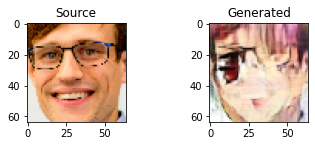

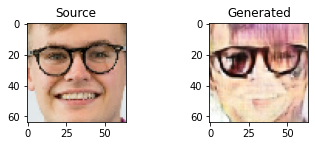

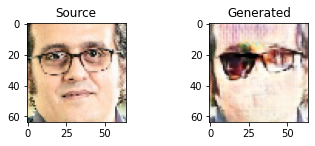

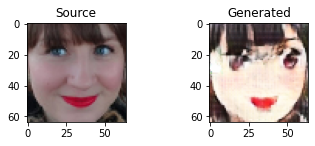

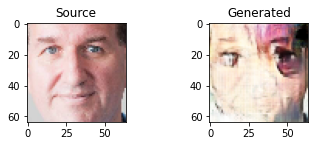

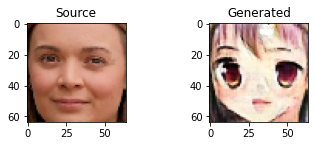

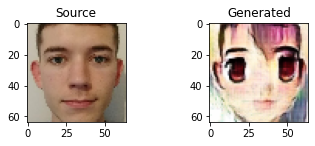

In [35]:
# Processing test images and generating fakes, plotting the results

image_shape = (64, 64, 3)
# loading test images
def load_image(filename, size=(64,64)):
	# load and resize the image
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# transform in a sample
	pixels = np.expand_dims(pixels, 0)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	return pixels

#utilising function above to load in test images
filepath_test = './Test images/'
test_list = list()
for file in os.listdir(filepath_test):
  pic = os.fsdecode(file)
  pic = os.path.join(filepath_test, file)
  pic = load_image(pic)
  test_list.append(pic)

# Loading weights and creating fake anime image based on test images
cust = {'InstanceNormalization': InstanceNormalization}
g_model_AtoB = define_generator(image_shape)
g_model_BtoA = define_generator(image_shape)
g_model_AtoB.load_weights('./g_model_AtoB_010004.h5')
g_model_BtoA.load_weights('./g_model_BtoA_010004.h5')

# translate image
image_transAB = list()
for i in range(len(os.listdir('./Test images/'))):
  image_transAB.append(g_model_AtoB.predict(test_list[i])) 
  # scale from [-1,1] to [0,1]
  image_transAB[i] = (image_transAB[i] + 1) / 2
  test_list[i] = (test_list[i] + 1) / 2

image_transBA = list()
for i in range(len(os.listdir('./Test images/'))):
  image_transBA.append(g_model_BtoA.predict(image_transAB[i])) 
  # scale from [-1,1] to [0,1]
  image_transBA[i] = (image_transBA[i] + 1) / 2

#plotting results
for i in range(len(os.listdir('./Test images/'))):
  fig = plt.figure()
  ax1 = fig.add_subplot(2,2,1)
  ax1.set_title('Source')
  ax1.imshow(test_list[i][0])
  ax2 = fig.add_subplot(2,2,2)
  ax2.set_title('Generated')
  ax2.imshow(image_transAB[i][0])

plt.show()

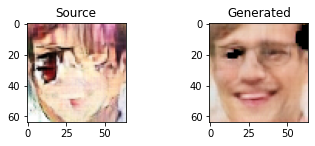

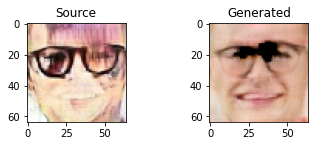

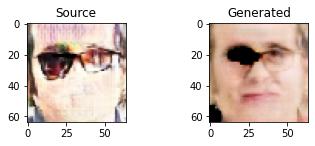

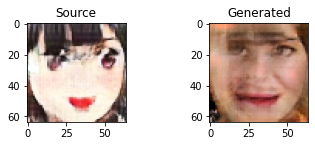

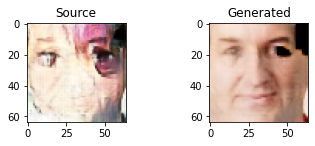

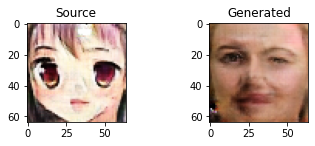

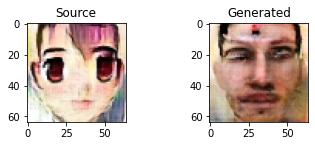

In [38]:
# Attempting to translate back to human

#plotting results
for i in range(len(os.listdir('./Test images/'))):
  fig = plt.figure()
  ax3 = fig.add_subplot(2,2,3)
  ax3.set_title('Source')
  ax3.imshow(image_transAB[i][0])
  ax4 = fig.add_subplot(2,2,4)
  ax4.set_title('Generated')
  ax4.imshow(image_transBA[i][0])

plt.show()

https://sthalles.github.io/advanced_gans/

https://github.com/nanoxas/anime-cyclegan

https://machinelearningmastery.com/cyclegan-tutorial-with-keras/

https://keras.io/examples/generative/cyclegan/
